

**Instructions:** Execute the scell below to check if the camera is opening. If it doesn’t open, please adjust the index accordingly. I have provided some basic comments for your understandstments!

In [2]:
import cv2
import ipywidgets as widgets
import threading
import time
from IPython.display import display

camera_widget = widgets.Image()#for camera widget

camera_index = 0 #according to your camera like if there are two camera both have different index
camera = cv2.VideoCapture(camera_index) #connection to specified camera

def update_camera_feed(): #for capturing and updating widget
    while True:
        ret, frame = camera.read() #ret is boolean value which tells weather image is captured or not and frame is the actual image
        if not ret:
            print("Error: Could not read frame.") #if image is not captured ret gives false indication
            break #bye bye update_camera_feed()
        
        _, jpeg = cv2.imencode('.jpg', frame) #it Convert the frame to JPEG format 
        camera_widget.value = jpeg.tobytes() #it updates the widget
        
        time.sleep(0.1)  # Add a delay to avoid overloading the kernel (your choice dpends on your system in mine it was working)


camera_thread = threading.Thread(target=update_camera_feed) # Start the camera feed thread it will keep calling this function
camera_thread.start()

display(camera_widget)# Display the camera feed in JupyterLab


Image(value=b'')

In [3]:
import torchvision.transforms as transforms
from src.dataset import ImageClassificationDataset

TASK = 'thumbs'  
CATEGORIES = ['thumbs_up', 'thumbs_down']
DATASETS = ['A', 'B']
#this is to transform the image before they are used by the model
TRANSFORMS = transforms.Compose([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

datasets = {}
for name in DATASETS:
    datasets[name] = ImageClassificationDataset(TASK + '_' + name, CATEGORIES, TRANSFORMS) #ImageClassificationDataset categorizes all the data  

print(f"{TASK} task with {CATEGORIES} categories initialized.")


thumbs task with ['thumbs_up', 'thumbs_down'] categories initialized.


In [4]:
import ipywidgets as widgets
import cv2
import numpy as np
from IPython.display import display

#these are for widgets which will be created for visual representation
dataset_widget = widgets.Dropdown(options=DATASETS, description='Dataset:')
category_widget = widgets.Dropdown(options=datasets[DATASETS[0]].categories, description='Category:')
count_widget = widgets.IntText(description='Count:')
save_widget = widgets.Button(description='Add')
refresh_widget = widgets.Button(description='Refresh Image')

#all the below functions are for the functionalities of widgets
def set_dataset(change):
    global dataset
    dataset = datasets[change['new']]
    count_widget.value = dataset.get_count(category_widget.value)


def update_counts(change):
    count_widget.value = dataset.get_count(change['new'])


def save(c):
    ret, frame = camera.read()
    if ret:
        datasets[dataset_widget.value].save_entry(frame, category_widget.value)
        count_widget.value = datasets[dataset_widget.value].get_count(category_widget.value)
    else:
        print("Error: No frame captured.")


def update_image(b):
    ret, frame = camera.read()
    if ret:
       
        _, jpeg = cv2.imencode('.jpg', frame)
        camera_widget.value = jpeg.tobytes()

#to observe change and updation accordingly
dataset_widget.observe(set_dataset, names='value')
category_widget.observe(update_counts, names='value')
save_widget.on_click(save)
refresh_widget.on_click(update_image)


data_collection_widget = widgets.VBox([
    camera_widget,
    dataset_widget,
    category_widget,
    count_widget,
    save_widget,
    refresh_widget
])
print("data_collection_widget initiated")

data_collection_widget initiated


In [5]:
import torch
import torchvision
import ipywidgets as widgets
#this is for different datasets like example- one for thumbs up-down and one for cat-dog
dataset = datasets['A']

#it will check if GPU is availaible using cuda or it will use cpu , using gpu will make it more faster
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# RESNET 18 it is trained to identify edges ,features and textures in a image
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, len(dataset.categories))

#moves the model to GPU or CPU
model = model.to(device)

#widgets button
model_save_button = widgets.Button(description='Save Model')
model_path_widget = widgets.Text(description='Model Path', value='my_model.pth')


def save_model(c):
    torch.save(model.state_dict(), model_path_widget.value)
    print("Model saved to", model_path_widget.value)

model_save_button.on_click(save_model)#to save the model trained


model_widget = widgets.VBox([
    model_path_widget,
    widgets.HBox([model_save_button])
])


print("Model configured and model_widget created")


Model configured and model_widget created


C:\Users\LAVITRA\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\LAVITRA\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import ipywidgets as widgets 
import time
import torch
import torch.nn.functional as F



BATCH_SIZE = 8 #8 images will be trained at a time
optimizer = torch.optim.Adam(model.parameters()) 

# for the widgets 
epochs_widget = widgets.IntText(description='epochs', value=1) #
eval_button = widgets.Button(description='evaluate')
train_button = widgets.Button(description='train')
loss_widget = widgets.FloatText(description='loss')
accuracy_widget = widgets.FloatText(description='accuracy')
progress_widget = widgets.FloatProgress(min=0.0, max=1.0, description='progress')

#this function is to train the images 
def train_eval(is_training):
    global BATCH_SIZE, model, dataset, optimizer, eval_button, train_button, accuracy_widget, loss_widget, progress_widget
    
    try:
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True
        )

        train_button.disabled = True
        eval_button.disabled = True
        time.sleep(1)

        model.train() if is_training else model.eval()
        
        while epochs_widget.value > 0:
            i = 0
            sum_loss = 0.0
            error_count = 0.0
            
            for images, labels in iter(train_loader):
                # Send data to device
                images = images.to(device)
                labels = labels.to(device)

                if is_training:
                    optimizer.zero_grad()

                
                outputs = model(images)

                # Compute loss
                loss = F.cross_entropy(outputs, labels)

                if is_training:
                    loss.backward()
                    optimizer.step()

                # Increment progress
                error_count += len(torch.nonzero(outputs.argmax(1) - labels).flatten())
                count = len(labels.flatten())
                i += count
                sum_loss += float(loss)
                progress_widget.value = i / len(dataset)
                loss_widget.value = sum_loss / i
                accuracy_widget.value = 1.0 - error_count / i
                
            if is_training:
                epochs_widget.value -= 1
            else:
                break
    except Exception as e:
        print(f"An error occurred: {e}")

    model.eval()
    train_button.disabled = False
    eval_button.disabled = False

train_button.on_click(lambda c: train_eval(is_training=True))
eval_button.on_click(lambda c: train_eval(is_training=False))

train_eval_widget = widgets.VBox([
    epochs_widget,
    progress_widget,
    loss_widget,
    accuracy_widget,
    widgets.HBox([train_button, eval_button])
])


print("trainer configured and train_eval_widget created")


trainer configured and train_eval_widget created


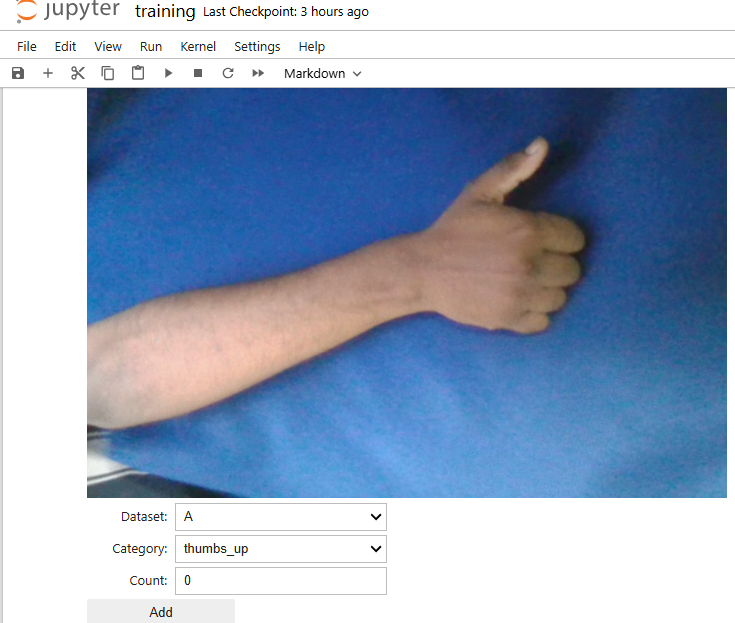


### Instructions for Capturing Dataset:

1. **Capture Photos for Thumbs Up**:
   - Start by taking a series of photos for the "thumbs up" gesture.
   - Ensure you capture images from various angles and lighting conditions to help the model learn to recognize the gesture in different scenarios.
   - Aim to take **multiple photos** (e.g., 50-100) to create a robust dataset for the "thumbs up" cow cell_**

2. **Capture Photos for Thumbs Down**:
   - Next, repeat the process for the "thumbs down" gesture.
   - Again, focus on capturing images from different angles and in various light
 any content, ensuring that all sections are included and visible. references, including the last one, are included and highlighted.u intend to place the figures without actually replacing any text!r text for the figures with actual images or references as needed!

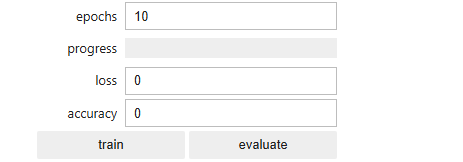
### Training the Model

1. **Set Epochs**: 
   - Increase the number of epochs to **10**. This means the model will go through the entire dataset 10 times, allowing it to learn more effectively from the training data.

2. **Start Training**:
   - After setting the epochs, click on the **"Train"** button. This will initiate the training process, during which the model will learn to recognize the thumbs up and thumbs down gestures based on the photos you’ve captured.

3. **Monitoring Progress**:
   - While the training is in progress, you can monitor the training metrics displayed, such as loss and accuracy. These metrics will give you an indication of how well the model is learning.

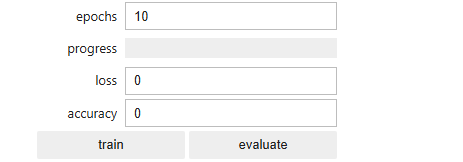
### Evaluating the Model

1. **Complete Training**: 
   - Once the training process is finished, review the training metrics (loss and accuracy) displayed on the interface. This information will help you understand how well the model has learned from the training data.

2. **Start Evaluation**: 
   - Click on the **"Evaluate"** button. This will trigger the evaluation process, allowing the model to test its performance on the dataset you provided.

3. **Understanding Evaluation Results**: 
   - During evaluation, the model will assess its accuracy in classifying the thumbs up and thumbs down gestures. 
   - The evaluation metrics will be displayed, providing insights into how well the model generalizes to unseen data.

4. **Next Steps**: 
   - Based on the evaluation results, you can decide whether to retrain the model with more epochs, adjust the dataset, or make changes to the model architecture to improve performance.

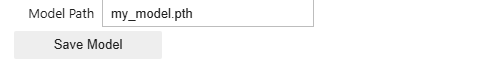
### Saving the Model and Transitioning to Testing

1. **Save the Model**: 
   - Click on the **"Save Model"** button to store your trained model. This action will save the model’s parameters and architecture, allowing you to reuse it later without retraining.

2. **Shutdown the Kernel**: 
   - After successfully saving the model, proceed to shut down the kernel. This will free up system resources and ensure that the environment is clean for the next session.

3. **Move to the Testing Notebook**: 
   - Navigate to your testing notebook where you will evaluate the saved model using new data. 
   - In this notebook, you will load the saved model and test its performance on unseen gestures.

4. **Ready for Testing**: 
   - Once in the testing notebook, follow the instructions there to load the model and start testing its accuracy on the data you provide.

In [9]:
import ipywidgets as widgets


data_live_box = widgets.HBox([data_collection_widget])
training_box = widgets.VBox([train_eval_widget, model_widget])

all_widget = widgets.VBox([data_live_box, training_box])

display(all_widget)
